In [73]:
from residual_learning.utils import (
                BaseForecaster, 
                ResidualForecasterDarts,
                TimeSeriesPreprocessor,
                crps
)
import pandas as pd
import matplotlib.pyplot as plt
import os
from darts import TimeSeries
from darts.metrics import smape, rho_risk
import numpy as np
import time

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
targets = pd.read_csv("targets.csv.gz")

The different sites are listed below:

In [2]:
targets["site_id"].unique()

array(['ARIK', 'BARC', 'BIGC', 'BLDE', 'BLUE', 'BLWA', 'CARI', 'COMO',
       'CRAM', 'CUPE', 'FLNT', 'GUIL', 'HOPB', 'KING', 'LECO', 'LEWI',
       'LIRO', 'MART', 'MAYF', 'MCDI', 'MCRA', 'OKSR', 'POSE', 'PRIN',
       'PRLA', 'PRPO', 'REDB', 'SUGG', 'SYCA', 'TECR', 'TOMB', 'TOOK',
       'WALK', 'WLOU'], dtype=object)

Loading the csv's

In [3]:
data_preprocessor = TimeSeriesPreprocessor()
data_preprocessor.load()

Let's first look at BARC which has every target series available

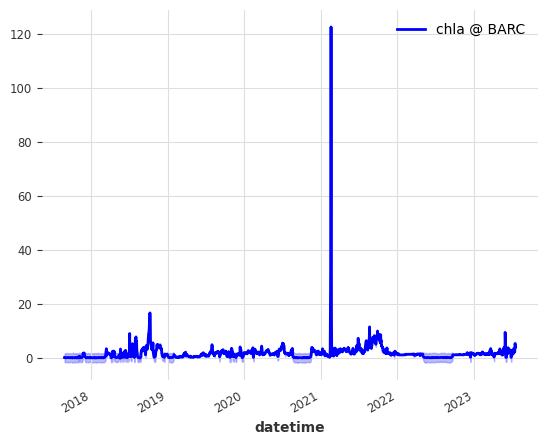

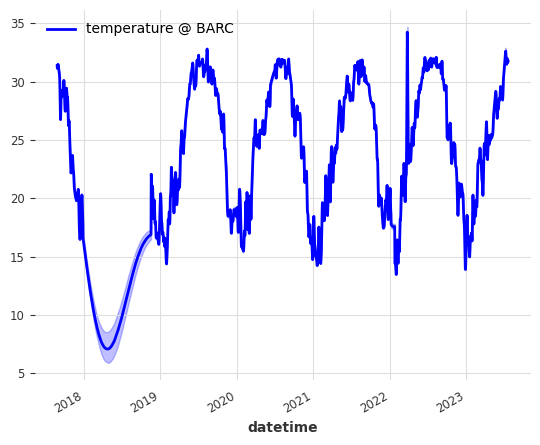

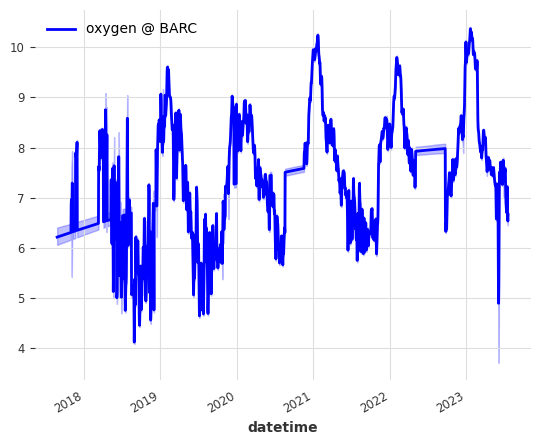

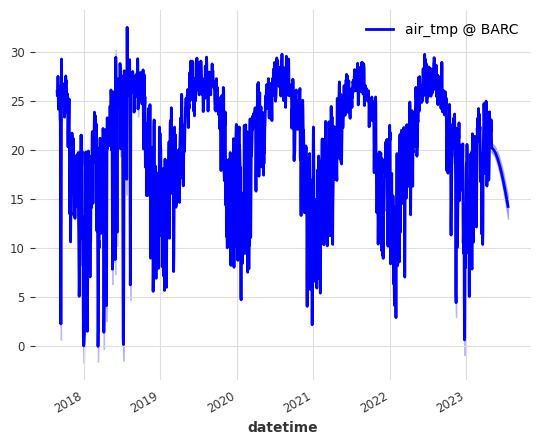

In [4]:
data_preprocessor.plot_by_site("BARC")

After running `python block_rnn.py &` and `python tcn.py &` on command line, let's look at the forecasts. Note this was for oxygen target series at BARC.

Need to make the following class so that it generates samples

In [313]:
class HistoricalForecaster():
    def __init__(self,
                 data_preprocessor: Optional = None,
                 output_csv_name: Optional[str] = "historical_forecaster_output.csv",
                 validation_split_date: Optional[str] = None, #YYYY-MM-DD
                 forecast_horizon: Optional[int] = 30,
                 site_id: Optional[str] = None,
                 target_variable: Optional[str] = None,
                 ):
        self.data_preprocessor = data_preprocessor
        self.output_csv_name = output_csv_name
        self.validation_split_date = validation_split_date
        self.forecast_horizon = forecast_horizon
        self.site_id = site_id
        self.target_variable = target_variable
        self._preprocess_data()
        self.make_forecasts()

    def _preprocess_data(self):
        stitched_series_dict = self.data_preprocessor.sites_dict[self.site_id]
        # If there was failure when doing the GP fit then we can't do preprocessing
        if self.target_variable in \
                self.data_preprocessor.sites_dict_null[self.site_id]:
            return "Cannot fit this target time series as no GP fit was performed."
        self.inputs = stitched_series_dict[self.target_variable]

        # Splitting training and validation set
        self.year = int(self.validation_split_date[:4])
        month = int(self.validation_split_date[5:7])
        day = int(self.validation_split_date[8:])
        split_date = pd.Timestamp(year=self.year, month=month, day=day)
        self.training_set, self.validation_set = self.inputs.split_before(split_date)

    def make_forecasts(self):
        """
        This function finds the historical mean and var, and uses these statistics for
        the forecast
        """
        # Using the medians of the GP filter
        median_df = self.training_set.median().pd_dataframe()
        median_df["timestamp"] = pd.to_datetime(median_df.index)
        median_df["day_of_year"] = median_df["timestamp"].dt.dayofyear
        self.median_df = median_df
        
        # Computing average and std for doy's 
        self.doy_df = self.median_df.groupby(['day_of_year'])['0'].agg(['mean', 'std'])
        self.doy_df = self.doy_df.fillna(method="ffill")
        
        # Filtering the previously computed averages and std for our dates of interest
        forecast_doys = pd.date_range(start=self.validation_split_date, 
                                      periods=self.forecast_horizon, 
                                      freq='D').dayofyear
        forecast_df = self.doy_df.loc[forecast_doys]

        # Function to give date from the numerical doy
        def day_of_year_to_date(year, day_of_year):
            base_date = datetime(year, 1, 1)
            target_date = base_date + timedelta(days=day_of_year - 1)
            return target_date

        samples = np.array([np.random.normal(self.doy_df.loc[self.doy_df.index == doy]["mean"],
                                    self.doy_df.loc[self.doy_df.index == doy]["std"]/2,
                                    size=(1, 500)) for doy in forecast_df.index])

        # Now creating an index going from doy to date
        date_index = [day_of_year_to_date(self.year, day) for day in forecast_df.index]
        forecast_df.index = date_index
        
        self.forecast_df = forecast_df
        self.forecast_ts = TimeSeries.from_times_and_values(forecast_df.index, samples)

    def historical_forecasts(self):
        # Finding the daily mean and std for every timestamp in training set
        historical_stats = self.median_df.merge(self.doy_df.reset_index(),
                                                on="day_of_year", 
                                                how="left")
        historical_stats.drop("0", axis=1, inplace=True)
        self.historical_stats = historical_stats.set_index("timestamp")

        # Now drawing samples so that we can create a Time Series
        samples = np.array([np.random.normal(self.historical_stats.iloc[i]["mean"], 
                                             self.historical_stats.iloc[i]["std"]/2, 
                                             size=(1,500))
                            for i in range(len(self.historical_stats))])

        self.historical_forecast = TimeSeries.from_times_and_values(
                                                   self.historical_stats.index,
                                                   samples)
        

    def plot(self):
        fig, ax1 = plt.subplots()
        ax1.plot(self.forecast_df.index, 
                 self.forecast_df["mean"], 
                 label="historical",
                 linewidth=2)
        ax1.fill_between(self.forecast_df.index, 
                         self.forecast_df["mean"] - self.forecast_df["std"], 
                         self.forecast_df["mean"] + self.forecast_df["std"],
                         alpha=0.2,)
        fig.autofmt_xdate()
        plt.legend()

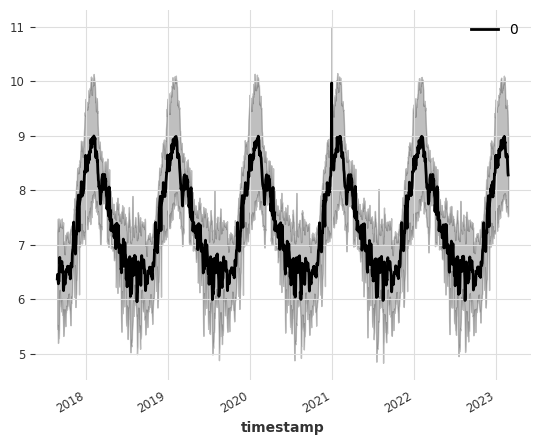

In [314]:
historical_model = HistoricalForecaster(data_preprocessor=data_preprocessor,
                          output_csv_name="historical_forecaster_output.csv",
                          validation_split_date="2023-02-26",
                          forecast_horizon=30,
                          site_id="BARC",
                          target_variable="oxygen")
historical_model.historical_forecasts()
historical_model.historical_forecast.plot()

The work for tomorrow is to make a comparison between historical forecaster and historical forecaster + adjusted residuals

In [315]:
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape

class ResidualForecasterDarts():
    def __init__(self,
                 historical_forecasts: Optional[TimeSeries] = None,
                 historical_ground_truth: Optional[TimeSeries] = None,
                 covariates: Optional[TimeSeries] = None,
                 output_csv_name: Optional[str] = "residual_forecaster_output.csv",
                 validation_split_date: Optional[str] = None, #YYYY-MM-DD
                 tune_model: Optional[bool] = False,
                 model_hyperparameters: Optional[dict] = None,
                 forecast_horizon: Optional[int] = 30
                 ):

        self.historical_forecasts = historical_forecasts
        self.historical_ground_truth = historical_ground_truth
        self.residuals = self.historical_ground_truth - self.historical_forecasts
        self.covariates = covariates
        self.output_csv_name = output_csv_name
        self.validation_split_date = validation_split_date
        self.forecast_horizon = forecast_horizon
        if model_hyperparameters == None:
            self.hyperparams = {"input_chunk_length": 180}
        else:
            self.hyperparams = model_hyperparameters
        self._preprocess_data()
 
        
    def _preprocess_data(self):
        """
        Divides input time series into training and validation sets
        """
        if self.covariates == None:
            # When Concatenating time series, they have to be the same lengths
            # so here I get the slice dates that will work across the different time series
            start_date = max(self.historical_forecasts.time_index[0],
                         self.historical_ground_truth.time_index[0])
            end_date = min(self.historical_forecasts.end_time(),
                           self.historical_ground_truth.end_time())
            
            self.historical_forecasts = self.historical_forecasts.slice(start_date, end_date)
            self.historical_ground_truth = self.historical_ground_truth.slice(start_date, end_date)
            # Adding the historical forecast and observed data to the covariates
            self.covariates = self.historical_forecasts.concatenate(self.historical_ground_truth,
                                                                    axis=1,
                                                                    ignore_time_axis=True)
        else:
            start_date = max(self.historical_forecasts.time_index[0],
                         self.historical_ground_truth.time_index[0],
                         self.covariates.time_index[0])
            end_date = min(self.historical_forecasts.end_time(),
                           self.historical_ground_truth.end_time(),
                           self.covariates.end_time())
            
            self.historical_forecasts = self.historical_forecasts.slice(start_date, end_date)
            self.historical_ground_truth = self.historical_ground_truth.slice(start_date, end_date)
            self.covariates = self.covariates.slice(start_date, end_date)
            # Adding the historical forecast and observed data to the covariates
            for time_series in [self.historical_forecasts, self.historical_ground_truth]:
                self.covariates = self.covariates.concatenate(time_series, axis=1, ignore_time_axis=True)

        # Getting the date so that we can create the training and test set
        year = int(self.validation_split_date[:4])
        month = int(self.validation_split_date[5:7])
        day = int(self.validation_split_date[8:])
        split_date = pd.Timestamp(year=year, month=month, day=day)
        self.residuals = self.residuals.slice(start_date, end_date)
        self.training_set, self.validation_set = self.residuals.split_before(split_date)

    
    def tune(self,
             input_chunk_length: Optional[list] = [31, 60, 180, 356],
             kernel_size: Optional[list] = [2, 3, 5],
             num_filters: Optional[list] = [1, 3, 5],
             num_layers: Optional[list] = [None, 1, 2, 3],
             dilation_base: Optional[list] = [1, 2, 3],
             dropout: Optional[list] = [0.1, 0.2, 0.3]):
        """
        Sets up Optuna trial to perform hyperparameter tuning
        """
        # The objective function will be called in the optuna loop
        def objective(trial):
            callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]
        
            # Selecting the hyperparameters
            input_chunk_length_ = trial.suggest_categorical("input_chunk_length", 
                                                               input_chunk_length)
            kernel_size_ = trial.suggest_categorical("kernel_size", kernel_size)
            num_filters_ = trial.suggest_categorical("num_filters", num_filters)
            num_layers_ = trial.suggest_categorical("num_layers", num_layers)
            dilation_base_ = trial.suggest_categorical("dilation_base", dilation_base)
            dropout_ = trial.suggest_categorical("dropout", dropout)

            tcn_model = TCNModel(input_chunk_length=input_chunk_length_,
                            kernel_size=kernel_size_,
                            num_filters=num_filters_,
                            dilation_base=dilation_base_,
                            output_chunk_length=self.forecast_horizon,
                            likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]))

            # Normalizing data to 0, 1 scale and fitting the model
            self.scaler = Scaler()
            training_set, covariates = self.scaler.fit_transform([self.training_set,
                                                                  self.covariates])
            tcn_model.fit(training_set,
                          past_covariates=covariates,
                          epochs=400, 
                          verbose=False)

            predictions = tcn_model.predict(n=len(self.validation_set[:self.forecast_horizon]), 
                                            past_covariates=covariates, 
                                            num_samples=50)
            predictions = self.scaler.inverse_transform(predictions)
            
            smapes = smape(self.validation_set[:self.forecast_horizon], 
                           predictions, 
                           n_jobs=-1, 
                           verbose=False)
            
            smape_val = np.mean(smapes)
            return smape_val if smape_val != np.nan else float("inf")


        study = optuna.create_study(direction="minimize")
        
        study.optimize(objective, n_trials=50) # INCREASE NUMBER OF TRIALS LATER ON
        
        # I save the best hyperparameters to the object self.hyperparameter so that these
        # hyperparameters can be easily referend in the future
        self.hyperparams = study.best_trial.params

    def make_residual_forecasts(self):
        """
        This function fits a TCN model to the residual error
        """
        # For clarity, I print the hyperparameters. Otherwise, following the standard
        # model fitting steps in Darts
        print(self.hyperparams)
        tcn = TCNModel(**self.hyperparams,
               output_chunk_length=self.forecast_horizon,
               likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]),
               random_state=0)
        self.scaler = Scaler()
        training_set, covariates = self.scaler.fit_transform([self.training_set,
                                                              self.covariates])

        tcn.fit(training_set,
                past_covariates=covariates,
                epochs=500, 
                verbose=False)

        predictions = tcn.predict(n=self.forecast_horizon,
                                  past_covariates=covariates, 
                                  num_samples=500)
        self.predictions = self.scaler.inverse_transform(predictions)

        self.predictions.pd_dataframe().to_csv(self.output_csv_name)

In [ ]:
residual_forecaster = ResidualForecasterDarts(
        historical_forecasts=historical_model.historical_forecast,
        historical_ground_truth=historical_model.training_set,
        covariates=None,
        validation_split_date="2023-01-28",
        output_csv_name = "trash_residual_forecaster.csv",
        forecast_horizon=7
)
residual_forecaster.make_residual_forecasts()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


{'input_chunk_length': 180}


In [ ]:
residual_forecaster.predictions.plot()

Function to create a plot comparing forecast, historical and observed data.

In [186]:
forecasts_dict = {}

In [187]:
def make_plot(csv_name, site, target_variable, record_dict):
    # Loading the forecast csv and creating a time series
    df = pd.read_csv(f"training_scripts/forecasts/{csv_name}.csv")
    times = pd.to_datetime(df["datetime"])
    times = pd.DatetimeIndex(times)
    values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((len(times), 1, -1))
    model_forecast = TimeSeries.from_times_and_values(times, 
                                                      values, 
                                                      fill_missing_dates=True, freq="D")

    # Presuming data_preprocessor has been called outside of the function
    # (not the best practice), create a validation series from it
    target_series = data_preprocessor.sites_dict[site][target_variable]
    validation_series = target_series.slice(times[0], times[-1]).median()

    # Now, making the forecast based off of historical mean and std
    historical_model = HistoricalForecaster(data_preprocessor=data_preprocessor,
                          output_csv_name="historical_forecaster_output.csv",
                          validation_split_date=str(model_forecast.time_index[0])[:10],
                          forecast_horizon=30,
                          site_id=site,
                          target_variable=target_variable)
    historical_model.make_forecasts()
    
    if site not in record_dict.keys():
        record_dict[site] = {target_variable: {csv_name: model_forecast}}
        record_dict[site][target_variable]["validation"] = validation_series
        # I need to make draw samples from historical would be best to just do this in utils
        record_dict[site][target_variable]["historical"] = historical_model.forecast_ts
    else:
        record_dict[site][target_variable][csv_name] = model_forecast    
    
    validation_series.plot(label="Truth")
    model_forecast.plot(label="Forecast")
    historical_model.forecast_ts.plot(label="historical")

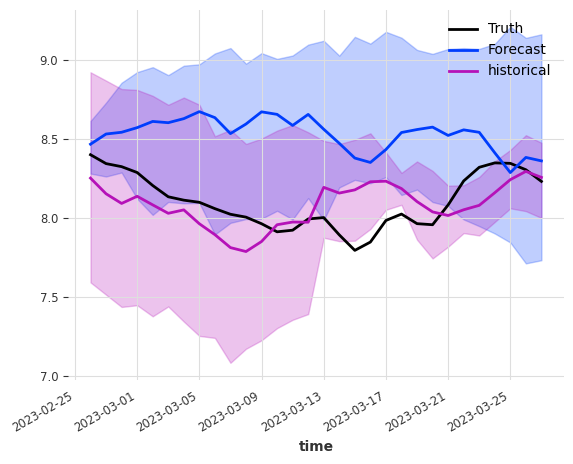

In [188]:
make_plot("block_rnn", "BARC", "oxygen", forecasts_dict)

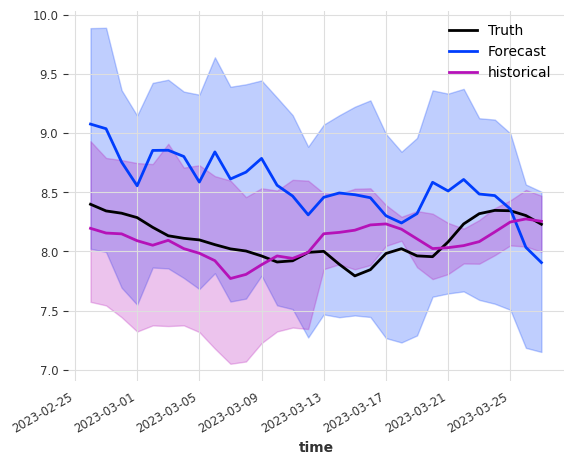

In [189]:
make_plot("tcn", "BARC", "oxygen", forecasts_dict)

Ok let's compare SMAPE and CRPS, first with CRPS.

In [190]:
block_crps = crps(forecasts_dict["BARC"]["oxygen"]["block_rnn"], forecasts_dict["BARC"]["oxygen"]["validation"])
tcn_crps = crps(forecasts_dict["BARC"]["oxygen"]["tcn"], forecasts_dict["BARC"]["oxygen"]["validation"])
historical_crps = crps(forecasts_dict["BARC"]["oxygen"]["historical"], forecasts_dict["BARC"]["oxygen"]["validation"])

Not the best plot selection here but going with it. Jitter plot in SNS way better.

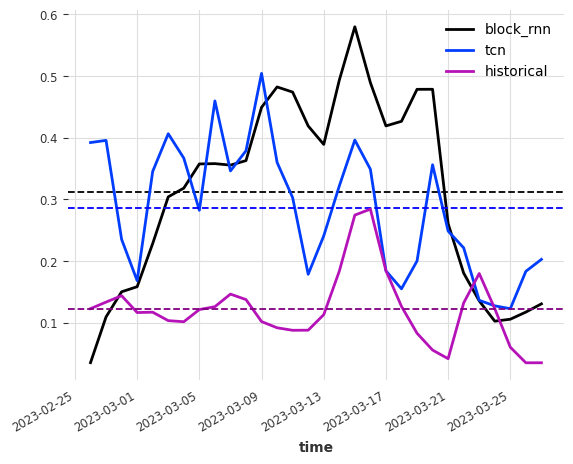

In [232]:
plt.clf()
block_crps.plot(label = "block_rnn")
plt.axhline(y = block_crps.mean(axis=0).values()[0][0], color = 'black', linestyle = '--')
tcn_crps.plot(label = "tcn")
plt.axhline(y = tcn_crps.mean(axis=0).values()[0][0], color = 'blue', linestyle = '--')
historical_crps.plot(label = "historical")
plt.axhline(y = historical_crps.mean(axis=0).values()[0][0], color = 'purple', linestyle = '--')
plt.show()

And, now with SMAPE

In [193]:
block_smapes = smape(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["block_rnn"], 
                     n_jobs=-1, 
                     verbose=False)

tcn_smapes = smape(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["tcn"], 
                     n_jobs=-1, 
                     verbose=False)

historical_smapes = smape(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["historical"], 
                     n_jobs=-1, 
                     verbose=False)

In [194]:
block_smapes, tcn_smapes, historical_smapes

(5.18028470325917, 5.826564064041284, 1.9122326174847306)

And, with rho risk

In [195]:
block_rho_50 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["block_rnn"],
                     rho=0.5,
                     verbose=False)

tcn_rho_50 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["tcn"], 
                     rho=0.5,
                     verbose=False)

historical_rho_50 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["historical"], 
                     rho=0.5,
                     verbose=False)

block_rho_05 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["block_rnn"],
                     rho=0.05,
                     verbose=False)

tcn_rho_05 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["tcn"], 
                     rho=0.05,
                     verbose=False)

historical_rho_05 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["historical"], 
                     rho=0.05,
                     verbose=False)

block_rho_95 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["block_rnn"],
                     rho=0.95,
                     verbose=False)

tcn_rho_95 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["tcn"], 
                     rho=0.95,
                     verbose=False)

historical_rho_95 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["historical"], 
                     rho=0.95,
                     verbose=False)

In [196]:
block_rho_05, tcn_rho_05, historical_rho_05

(0.08126538384662846, 0.053911427992865184, 0.0014966581552925146)

In [197]:
block_rho_50, tcn_rho_50, historical_rho_50

(0.0533452282821601, 0.04693386112683963, 0.002850742501799412)

In [198]:
block_rho_95, tcn_rho_95, historical_rho_95

(0.0064216792762933515, 0.006512460441479214, 0.0009123929066245629)